# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [52]:
# imports
import pandas as pd
import panel as pn
import os
from pathlib import Path
from dotenv import load_dotenv
from panel import widgets
import plotly.express as px

In [53]:
pn.extension('plotly')

In [54]:
import hvplot.pandas

In [55]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [56]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

coordinates_data = pd.read_csv(Path("Data/neighborhoods_coordinates.csv")).dropna()
coordinates_data.drop_duplicates(inplace=True)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [57]:
def get_housing_units_yearly():
    """Creating Housing Units Per Year DF"""
    housing_units_yearly = (
        sfo_data[["housing_units"]]
        .groupby([sfo_data.index])
        .mean()
        .reset_index()
    )
    columns = ["Year", "Housing Units"]
    housing_units_yearly.columns = columns
    
    return housing_units_yearly

In [58]:
def get_avg_housing_sale_price():
    """Creating Average Sale Price in San Francisco Per Year DF"""
    avg_housing_sale_price = (
        sfo_data[["sale_price_sqr_foot"]]
        .groupby(sfo_data.index)
        .mean()
        .reset_index()
    )
    columns = ["Year", "Price per SqFt"]
    avg_housing_sale_price.columns = columns
    
    return avg_housing_sale_price

In [59]:
def get_avg_housing_rent():
    """Creating Average Gross Rent in San Francisco Per Year DF"""
    avg_housing_rent = (
        sfo_data[["gross_rent"]]
        .groupby(sfo_data.index)
        .mean()
        .reset_index()
    )
    columns = ["Year", "Gross Rent"]
    avg_housing_rent.columns = columns
    
    return avg_housing_rent

In [60]:
def get_neighborhood_avg():
    """Creating Average Prices by Neighborhood DF"""
    neighborhood_avg = (
        sfo_data
        .groupby([sfo_data.index, "neighborhood"])
        .mean()
        .reset_index()
    )
    columns = ["Year", "Neighborhood", "Avg. Sale Price per Square Foot", "Housing Units", "Gross Rent"]
    neighborhood_avg.columns = columns
    
    return neighborhood_avg

In [61]:
def get_most_expensive_neighborhoods():
    """Creating Top 10 Most Expensive Neighborhoods DF"""
    expensive_neighborhoods = (
        sfo_data
        .reset_index(drop=True)
        .groupby(["neighborhood"])
        .mean()
        .sort_values("sale_price_sqr_foot", ascending=False)
        .reset_index()
        .round(2)
    )
    columns = ["Neighborhood", "Avg. Sale Price per Square Foot", "Housing Units", "Gross Rent"]
    expensive_neighborhoods.columns = columns
    top_most_expensive_neighborhoods = expensive_neighborhoods[:10]
    
    return top_most_expensive_neighborhoods

In [62]:
def get_most_expensive_neighborhoods_yearly():
    """Creating Most Expensive Neighborhood Prices DF"""
    most_expensive_neighborhoods = (
        get_neighborhood_avg()
        .groupby(["Neighborhood", "Gross Rent", "Avg. Sale Price per Square Foot"])
        .mean()
        .reset_index()
        .round(2)
    )
    
    exp_neighborhood = []
    exp_neighborhood_df = get_most_expensive_neighborhoods()["Neighborhood"]

    for neighborhood in exp_neighborhood_df:
        exp_neighborhood.append(neighborhood)

    most_expensive_neighborhood_data = (
        most_expensive_neighborhoods[most_expensive_neighborhoods["Neighborhood"].isin(exp_neighborhood)]
    )
    
    return most_expensive_neighborhood_data

In [63]:
def get_neighborhood_data():     
    "Creating Neighborhood Locations and Avg Values DF"
    neighborhood_avg_values = (
        sfo_data
        .groupby(["neighborhood"])
        .mean()
        .reset_index()
    )
    
    neighborhood_data_df = pd.concat(
    [coordinates_data, neighborhood_avg_values],
    axis=1,
    )
    
    neighborhood_data_df = neighborhood_data_df.drop(columns = ["neighborhood"])
    neighborhood_data_df = neighborhood_data_df.rename(columns = {
        "Lat" : "Latitude",
        "Lon" : "Longitude",
        "sale_price_sqr_foot" : "Avg Sale Price per Square Foot",
        "housing_units" : "Housing Units",
        "gross_rent" : "Gross Rent"
    })
    
    return neighborhood_data_df

In [64]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    housing_units_yearly = get_housing_units_yearly()
    housing_units_yearly_plot = housing_units_yearly.hvplot.bar( 
        x="Year", 
        y="Housing Units",
        ylim=(370000, 387000),
        width=900,
        height=500,
        title="Housing Units in San Francsico from 2010 to 2016"
    ).opts(yformatter="%.0f")
    
    return housing_units_yearly_plot

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    avg_housing_rent = get_avg_housing_rent()
    gross_rent_avg_plot = avg_housing_rent.hvplot(
        x="Year",
        y="Gross Rent",
        width=900,
        height=500,
        title="Average Gross Rent by Year",
        color="g"
    )
    
    return gross_rent_avg_plot

def average_sale_price():
    """Average Sales Price Per Year."""
    avg_housing_sale_price = get_avg_housing_sale_price()
    sale_price_avg_plot = avg_housing_sale_price.hvplot(
        x="Year",
        y="Price per SqFt",
        width=900,
        height=500,
        title="Average Price per SqFt by Year",
        color="r"
    )
    
    return sale_price_avg_plot

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    neighborhood_avg = get_neighborhood_avg()
    neighborhood_avg_price_plot = neighborhood_avg.hvplot(
        x="Year",
        y="Avg. Sale Price per Square Foot",
        groupby="Neighborhood",
        width=800,
        height=500,
        title="Average Price per SqFt by Year"
    )
    
    return neighborhood_avg_price_plot

def average_rent_by_neighborhood():
    """Average Gross Rent by Neighborhood"""
    neighborhood_avg = get_neighborhood_avg()
    neighborhood_avg_rent_plot = neighborhood_avg.hvplot(
        x="Year",
        y="Gross Rent",
        groupby="Neighborhood",
        width=800,
        height=500,
        title="Monthly Rent by Year"
    )

    return neighborhood_avg_rent_plot

def all_neighborhood_rent_sales():
    """Most Expensive Neighborhood Prices"""
    all_neighborhood_rent_sales = get_neighborhood_avg()
    all_neighborhood_rent_sales_plot = all_neighborhood_rent_sales.hvplot.bar(
        x="Year",
        y=["Gross Rent", "Avg. Sale Price per Square Foot"],
        xlabel= "Year",
        ylabel = "Housing Units",
        groupby="Neighborhood",
        title="Sale Price per SqFt & Gross Rent by Year",
        rot=90,
        width=800,
        height=600
    )
    
    return all_neighborhood_rent_sales_plot
    
def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods.""" 
    most_expensive_neighborhoods = get_most_expensive_neighborhoods()
    most_expensive_neighborhoods_plot = most_expensive_neighborhoods.hvplot.bar(
        x="Neighborhood",
        y="Avg. Sale Price per Square Foot",
        title="Top 10 Expensive Neighborhoods in SFO",
        rot=90,
        width=1000,
        height=600,
        ylim=(600,950)
    )

    return most_expensive_neighborhoods_plot

def most_expensive_neighborhoods_rent_sales():
    """Most Expensive Neighborhood Prices"""
    most_expensive_neighborhoods_yearly = get_most_expensive_neighborhoods_yearly()
    expensive_rent_neighborhood_plot = most_expensive_neighborhoods_yearly.hvplot.bar(
        x="Year",
        y=["Gross Rent", "Avg. Sale Price per Square Foot"],
        xlabel= "Year",
        ylabel = "Housing Units",
        groupby="Neighborhood",
        title="Expensive Neighborhood Sale Price per SqFt & Gross Rent by Year",
        rot=90,
        width=800,
        height=600
    )
    
    return expensive_rent_neighborhood_plot
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    most_expensive_neighborhoods = get_most_expensive_neighborhoods()
    parallel_coordinates_plot = px.parallel_coordinates(
        most_expensive_neighborhoods,
        color="Avg. Sale Price per Square Foot",
        dimensions=["Avg. Sale Price per Square Foot", "Housing Units", "Gross Rent"],
        color_continuous_scale=px.colors.sequential.Inferno,
        title="Parallel Coordinates Analysis of Most Expensive San Francisco Neighborhoods",
        width=1000,
        height=600
    )
    
    return parallel_coordinates_plot


def parallel_categories():
    """Parallel Categories Plot."""
    most_expensive_neighborhoods = get_most_expensive_neighborhoods()
    parallel_categories_plot = px.parallel_categories( 
        most_expensive_neighborhoods,
        dimensions=["Neighborhood", "Avg. Sale Price per Square Foot", "Housing Units", "Gross Rent"],
        color="Avg. Sale Price per Square Foot",
        color_continuous_scale=px.colors.sequential.Inferno,
        title="Parallel Categories Analysis of Most Expensive San Francisco Neighborhoods",
        width=1000,
        height=600
    )
    
    return parallel_categories_plot 

def neighborhood_map():
    """Neighborhood Map."""    
    neighborhood_data = get_neighborhood_data()
    neighborhood_scatter_plot = px.scatter_mapbox(
        neighborhood_data,
        lat="Latitude",
        lon="Longitude",
        hover_name="Neighborhood",
        color="Gross Rent",
        size="Avg Sale Price per Square Foot",
        color_continuous_scale=px.colors.cyclical.IceFire,
        title="Average Sale Price per Square Foot & Gross Rent in San Francisco",
        width=1000,
        height=700
    )
    
    return neighborhood_scatter_plot

def sunburst():
    """Sunburst Plot."""
    expensive_neighborhoods_yearly = get_most_expensive_neighborhoods_yearly()
    sunburst_plot = px.sunburst(
        expensive_neighborhoods_yearly,
        path=["Year", "Neighborhood"],
        color="Gross Rent",
        color_continuous_scale=px.colors.sequential.Blues,
        title="Cost Analysis of Most Expensive Neighborhoods",
        width=900,
        height=700
    )

    return sunburst_plot

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [65]:
# Create a Title for the Dashboard

avg_sale_rent_col = pn.Column(
    "## Average Housing Sale Price and Average Gross Rent by Year Graphs",
    average_sale_price(),
    average_gross_rent(),
)

expensive_neighborhood_parallels_col = pn.Column(
    "## Top Most Expensive Neighborhood Multivariable Analysis Graphs",
    parallel_coordinates(),
    parallel_categories()
)

sunburst_col = pn.Column(
    "## Top Most Expensive Neighborhood Cost Anaylysis by Year",
    sunburst()
)

avg_sale_rent_by_neighborhood_col = pn.Column(
    "## Average Sale Price per SqFt & Gross Rent by Neighborhood Graphs",
    average_price_by_neighborhood(),
    average_rent_by_neighborhood()
)

all_neighborhood_rent_sales_col = pn.Column(
    "## All Neighborhood Data by Year",
    all_neighborhood_rent_sales()
)

housing_units_col = pn.Column(
    "## Average Housing Units by Year Graph",
    housing_units_per_year()
)

expensive_neighborhoods_col = pn.Column(
    "## Top Most Expensive Neighborhoods & Yearly Data by Neighborhood Graphs",
    top_most_expensive_neighborhoods(),
    most_expensive_neighborhoods_rent_sales()
)

neighborhood_map_col = pn.Column(
    "# San Francisco Real Estate Interactive Dashboard",
    "## San Francisco Neighborhood Map",
    neighborhood_map()
)

# Create a tab layout for the dashboard
# YOUR CODE HERE!
sf_realestate_dashboard = pn.Tabs(
    ("Neighborhood Map", neighborhood_map_col),
    ("Housing Units Annually", housing_units_col),
    ("Sale Price & Gross Rent", avg_sale_rent_col),
    ("Sale Price & Gross Rent by Neighborhood", avg_sale_rent_by_neighborhood_col),
    ("All Neighborhood Data", all_neighborhood_rent_sales_col),
    ("Expensive Neighborhoods", expensive_neighborhoods_col),
    ("Expensive Neighborhoods Analysis", expensive_neighborhood_parallels_col),
    ("Expensive Neighborhoods Cost Analysis", sunburst_col)
)

# Create the dashboard
sf_realestate_dashboard

ValueError: failed to validate PlotlyPlot(id='2799', ...).config: expected an element of Dict(String, Any), got None

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Plotly(Figure)
    [1] Column
        [0] Markdown(str)
        [1] HoloViews(Bars)
    [2] Column
        [0] Markdown(str)
        [1] HoloViews(Curve)
        [2] HoloViews(Curve)
    [3] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='Neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [2] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='Neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [4] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0

## Serve the Panel Dashboard

In [66]:
# Serve the# dashboard
sf_realestate_dashboard.servable()

ValueError: failed to validate PlotlyPlot(id='2805', ...).config: expected an element of Dict(String, Any), got None

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Plotly(Figure)
    [1] Column
        [0] Markdown(str)
        [1] HoloViews(Bars)
    [2] Column
        [0] Markdown(str)
        [1] HoloViews(Curve)
        [2] HoloViews(Curve)
    [3] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='Neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [2] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='Neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [4] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [67]:
housing_units_per_year()

:Bars   [Year]   (Housing Units)

In [68]:
average_gross_rent()

:Curve   [Year]   (Gross Rent)

In [69]:
average_sale_price()

:Curve   [Year]   (Price per SqFt)

In [70]:
average_price_by_neighborhood()

:DynamicMap   [Neighborhood]
   :Curve   [Year]   (Avg. Sale Price per Square Foot)

In [26]:
average_rent_by_neighborhood()

:DynamicMap   [Neighborhood]
   :Curve   [Year]   (Gross Rent)

In [27]:
all_neighborhood_rent_sales()

:DynamicMap   [Neighborhood]
   :Bars   [Year,Variable]   (value)

In [28]:
top_most_expensive_neighborhoods()

:Bars   [Neighborhood]   (Avg. Sale Price per Square Foot)

In [29]:
most_expensive_neighborhoods_rent_sales()

:DynamicMap   [Neighborhood]
   :Bars   [Year,Variable]   (value)

In [46]:
neighborhood_map().show()

In [31]:
parallel_categories()

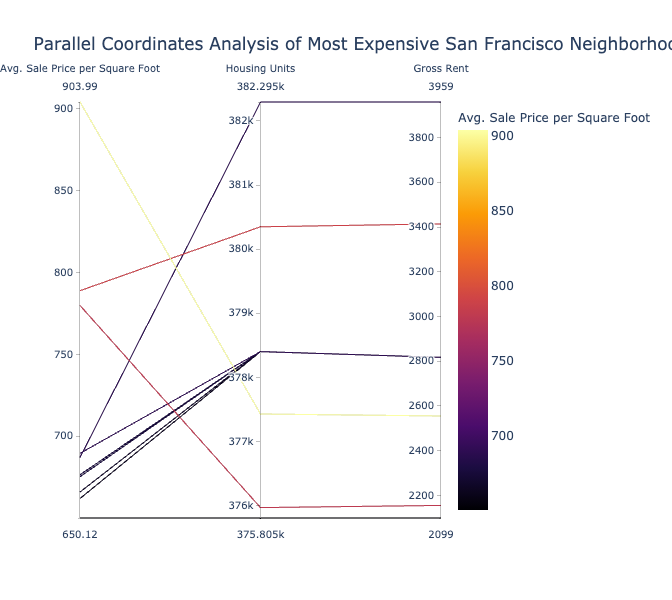

In [86]:
parallel_coordinates()

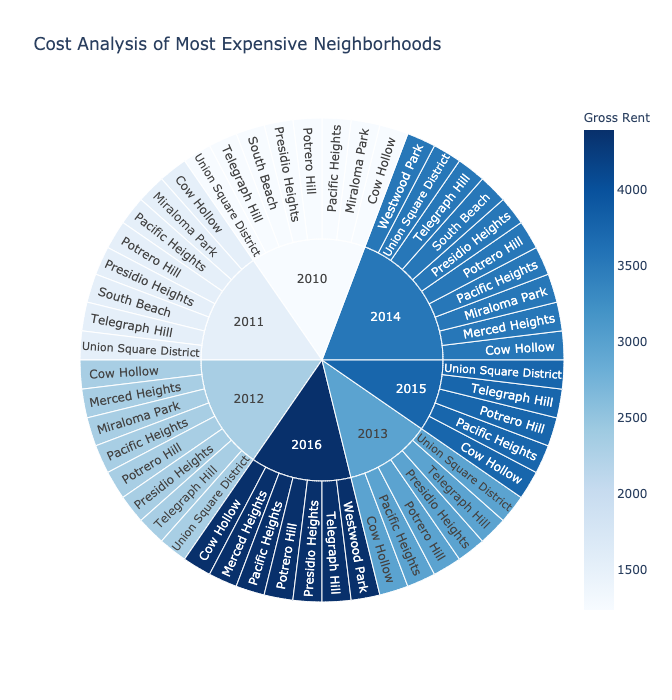

In [87]:
sunburst()